In [1]:
#CROPP CODE FOR IMAGE TRAINING
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
%matplotlib inline
import tensorflow as tf
from time import time
from tensorflow import estimator
tf.reset_default_graph()
from sklearn.model_selection import train_test_split
gs = 0
N_CLASSES = 4   
IMG_W = 200      # for better visibility, go with >180
IMG_H = 200
learning_rate = 0.001     #slow learning rate for better learning
MODEL = './model{}'.format(time())
NUM_EPOCH = 100
BATCH_SIZE = 16
LOOP = 16                # total no. of epoch = loop * 2*num_epoch
disease ={0:'Healthy', 
          1:'Mosaic_Virus', 
          2:'rust', 
          3:'woolyaphids'}       
def normalize(df):    
    return (df - df.min()) / (df.max() - df.min())
def denormalize(df,norm_data):    
    return (norm_data * (df.max() - df.min())) + df.min()

In [2]:
def getdata(path):
    ''' returns shuffled array of image file path and labels of corresponding file '''
    woolyaphids = []
    woolyaphids_l= []
    Healthy = []
    Healthy_l = []
    Mosaic_Virus = []
    Mosaic_Virus_l = []
    rust = []
    rust_l = []
    for file in os.listdir(path):
        name=file.split(sep='.')
        if 'healthy' in name[0]:
            Healthy.append(path+file)
            Healthy_l.append(0)
        elif 'Mosaic_Virus' in name[0]:
            Mosaic_Virus.append(path+file)
            Mosaic_Virus_l.append(1)
        elif 'mosaic_virus' in name[0]:
            Mosaic_Virus.append(path+file)
            Mosaic_Virus_l.append(1)
        elif 'rust' in name[0]:
            rust.append(path+file)
            rust_l.append(2)
        elif 'Woolyaphids' in name[0]:
            woolyaphids.append(path+file)
            woolyaphids_l.append(3)
        elif 'woolyaphids' in name[0]:
            woolyaphids.append(path+file)
            woolyaphids_l.append(3)
            
    image_list = np.hstack((Healthy, Mosaic_Virus, rust, woolyaphids ))
    label_list = np.hstack(( Healthy_l, Mosaic_Virus_l, rust_l, woolyaphids_l))
    temp = np.array([image_list, label_list])
    temp = temp.transpose()
    np.random.shuffle(temp)
    image_list = list(temp[:, 0])
    label_list = list(temp[:, 1])
    label_list = [int(i) for i in label_list]
    print("Healthy plant is: ", len(Healthy))
    print("Rust disease plant is: ", len(rust))
    print("Mosaic_Virus plant is: ", len(Mosaic_Virus))
    print("Woolyaphids plant is: ", len(Mosaic_Virus))
    return image_list, label_list

def process(path):
    a, train_labels = getdata(path)
    img = []
    batch=len(a)
    for i in range(batch):
        im = cv2.imread(a[i], cv2.IMREAD_COLOR) 
        b,g,r = cv2.split(im)
        image = cv2.merge([r,g,b])
        res = cv2.resize(image,(IMG_W, IMG_H), interpolation = cv2.INTER_CUBIC)
        img.append(res)
        if i%50 == 0: print('Processed {} of {}'.format(i, batch))
        
    print("finished\nCount of Images is ",len(img),"with input shape",res.shape)
    return np.array(img, dtype=np.int32), np.array(train_labels[:batch], dtype = np.int32)


In [3]:
path = '../../AllData/DNN_Data/NewData/disease/input/'
X, Y = process(path)

Healthy plant is:  155
Rust disease plant is:  136
Mosaic_Virus plant is:  151
Woolyaphids plant is:  151
Processed 0 of 592
Processed 50 of 592
Processed 100 of 592
Processed 150 of 592
Processed 200 of 592
Processed 250 of 592
Processed 300 of 592
Processed 350 of 592
Processed 400 of 592
Processed 450 of 592
Processed 500 of 592
Processed 550 of 592
finished
Count of Images is  592 with input shape (200, 200, 3)


In [4]:
pwd

'/Users/aayushsingh/Desktop/RGIT/CDDD/Models/DNN1'

In [5]:
data = []
for i in X:
    data.append(i.reshape(IMG_W*IMG_H*3))
data = np.array(data)

In [6]:
print('shape of whole data and their labels are as follows',data.shape,'and',Y.shape,"respectively")

shape of whole data and their labels are as follows (592, 120000) and (592,) respectively


actually it is: Mosaic_Virus


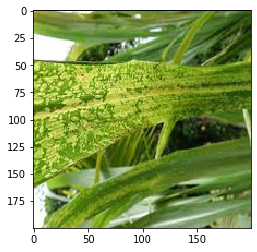

actually it is: Healthy


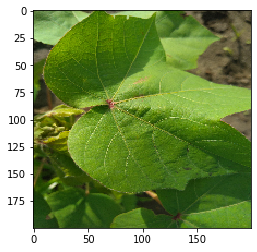

actually it is: woolyaphids


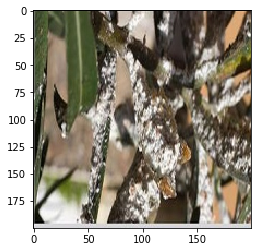

actually it is: Mosaic_Virus


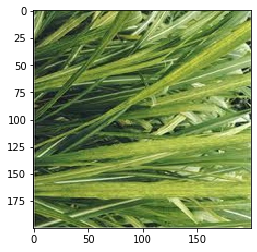

actually it is: Mosaic_Virus


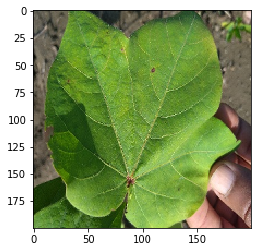

actually it is: woolyaphids


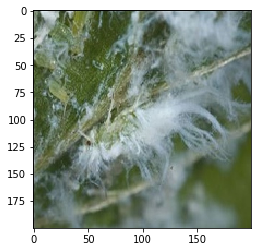

actually it is: Mosaic_Virus


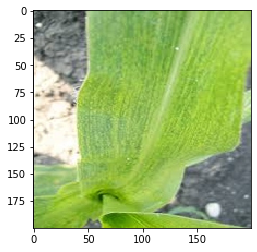

actually it is: Healthy


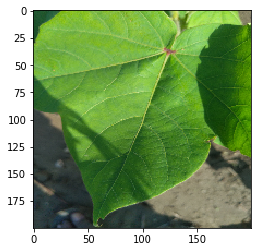

actually it is: rust


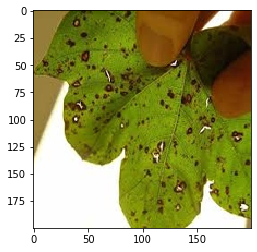

actually it is: woolyaphids


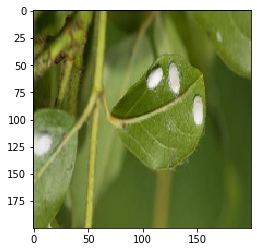

In [7]:
for i in range(170, 180):
    j =data[i].reshape(IMG_W,IMG_H,3)
    print("actually it is:",disease[Y[i]])
    plt.imshow(j)
    plt.show()  
#this cell is used to ensure proper labelling of image

In [8]:
X_train, X_val, Y_train, Y_val = train_test_split(data ,Y, test_size=0.3, random_state=1)

In [9]:
X_tr = []
for i in X_train:
    X_tr.append(normalize(i))
X_tr = np.array(X_tr)

X_v = []
for i in X_val:
    X_v.append(normalize(i))
X_v = np.array(X_v)

In [10]:
feat_cols=[tf.feature_column.numeric_column('x', shape=[IMG_H*IMG_W*3])]

In [11]:
deep_model = tf.estimator.DNNClassifier(feature_columns=feat_cols, 
                                      n_classes=N_CLASSES,
                                      hidden_units=[100, 100, 100, 100, 100,50], 
                                      activation_fn=tf.nn.leaky_relu,
                                      optimizer=tf.train.GradientDescentOptimizer(learning_rate),
                                      model_dir=MODEL)

In [12]:
input_fn = estimator.inputs.numpy_input_fn(x={'x':np.array(X_tr)}, 
                                           y=np.array(Y_train),
                                           shuffle= True,
                                           num_epochs=NUM_EPOCH,
                                           batch_size=BATCH_SIZE)

In [13]:
input_fn_eval = estimator.inputs.numpy_input_fn(x = {'x':np.array(X_v)},
                                                y = Y_val,
                                                shuffle=False)

In [14]:
for i in range(LOOP):
    gs = gs + NUM_EPOCH*2
    train_spec = tf.estimator.TrainSpec(input_fn = input_fn, max_steps = gs)
    eval_spec  = tf.estimator.EvalSpec(input_fn = input_fn_eval)
    tf.estimator.train_and_evaluate(deep_model, train_spec, eval_spec)
    print("*************************************************************************************** step = ", i)

W1106 09:47:25.676409 4549602752 deprecation.py:323] From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/training/training_util.py:236: Variable.initialized_value (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
W1106 09:47:25.706294 4549602752 deprecation.py:323] From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow_estimator/python/estimator/inputs/queues/feeding_queue_runner.py:62: QueueRunner.__init__ (from tensorflow.python.training.queue_runner_impl) is deprecated and will be removed in a future version.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
W1106 09:47:25.709249 4549602752 deprecation.py:323] From /Library/Frameworks/Python.framework/Versions/3.7/lib/pyth

*************************************************************************************** step =  0


W1106 09:47:47.187405 4549602752 deprecation.py:323] From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/training/saver.py:1066: get_checkpoint_mtimes (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file utilities to get mtimes.


*************************************************************************************** step =  1
*************************************************************************************** step =  2
*************************************************************************************** step =  3


W1106 09:48:41.792246 4549602752 deprecation.py:323] From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/training/saver.py:960: remove_checkpoint (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to delete files with this prefix.


*************************************************************************************** step =  4
*************************************************************************************** step =  5
*************************************************************************************** step =  6
*************************************************************************************** step =  7
*************************************************************************************** step =  8
*************************************************************************************** step =  9
*************************************************************************************** step =  10
*************************************************************************************** step =  11
*************************************************************************************** step =  12
*************************************************************************************** step =  13
****************

In [15]:
input_fn_eval = estimator.inputs.numpy_input_fn( x = {'x':X_v},
                                                shuffle = False)

preds=deep_model.predict(input_fn=input_fn_eval)

In [16]:
predictions = [p['class_ids'][0] for p in preds]

In [17]:
pred = np.asarray(predictions)

prediction is: rust 
actually it is: rust


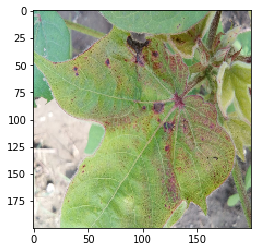

prediction is: woolyaphids 
actually it is: woolyaphids


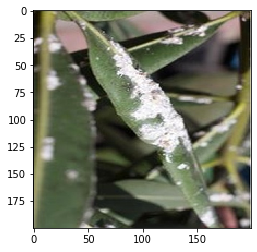

prediction is: Healthy 
actually it is: Healthy


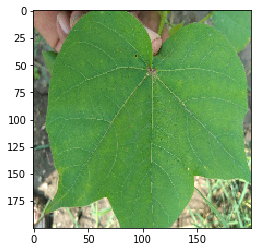

prediction is: rust 
actually it is: rust


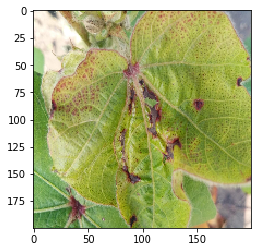

prediction is: Healthy 
actually it is: Mosaic_Virus


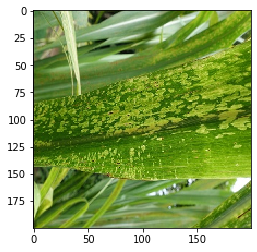

prediction is: Mosaic_Virus 
actually it is: Mosaic_Virus


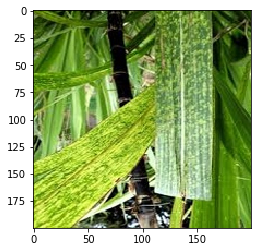

prediction is: woolyaphids 
actually it is: woolyaphids


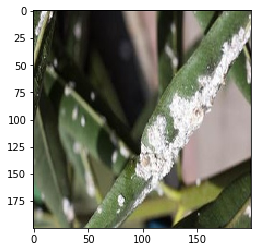

prediction is: Mosaic_Virus 
actually it is: Mosaic_Virus


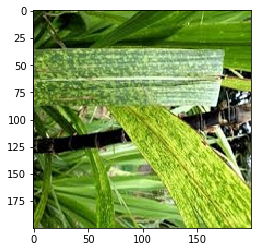

prediction is: Healthy 
actually it is: Healthy


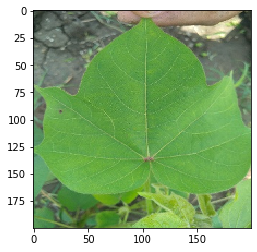

prediction is: Healthy 
actually it is: Healthy


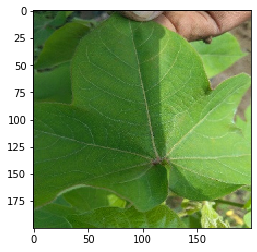

151


In [20]:
for i in range(17,27):
    j = X_v[i].reshape(IMG_W,IMG_H,3)
    print("prediction is:", disease[pred[i]],"\nactually it is:",disease[Y_val[i]])
    plt.imshow(j)
    plt.show()   
cor = 0
for i in range(len(pred)):
    if disease[pred[i]]==disease[Y_val[i]]:
        cor = cor + 1
        
print(cor)


In [19]:
f = pred == Y_val
print(len(f))
T = len(f[f == True])
F = len(f[f == False])
print(T, F, T+F)
error = F/(T+F) * 100
print(error)

178
151 27 178
15.168539325842698
